### Bibliotecas 

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
#from pyspark.sql.functions import format_number,dayofmonth,hour,dayofyear,month,year,weekofyear,date_format
#from pyspark.ml.clustering import KMeans
#from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

In [3]:
spark = SparkSession.builder.appName("Word2Vec - Covid19 Tweets").getOrCreate()

In [4]:
data = spark.read.csv('text.csv', header = True)

In [5]:
#data = data.na.drop(how='any')

In [6]:
data.show()

+--------------------+
|     tweets_tratados|
+--------------------+
|agenciabrasil cov...|
|tudo sobre corona...|
|agenciabrasil cov...|
|avozdobrasil  gov...|
|tvbrasilgov  govb...|
|imirante dados at...|
|agenciabrasil cov...|
|dados atualizados...|
|agenciabrasil cov...|
|portaluai azitrom...|
|azitromicina efic...|
|covid  brasil  mi...|
|saudepoa situação...|
|em_com criador ki...|
|mnewstv boletim c...|
|boletim coronavir...|
|em_com criador ki...|
|dados_covid atual...|
|atualização dados...|
|em_com criador ki...|
+--------------------+
only showing top 20 rows



In [7]:
data.count()

5141

In [10]:
tokenizer = Tokenizer(inputCol="tweets_tratados", outputCol="words")

In [11]:
wordsData = tokenizer.transform(data)

In [29]:
word2Vec = Word2Vec(vectorSize=200, minCount=0, inputCol="words", outputCol="result", seed = 42)
model = word2Vec.fit(wordsData)

In [30]:
result = model.transform(wordsData)

In [31]:
result.show()

+--------------------+--------------------+--------------------+
|     tweets_tratados|               words|              result|
+--------------------+--------------------+--------------------+
|agenciabrasil cov...|[agenciabrasil, c...|[-0.0177149264511...|
|tudo sobre corona...|[tudo, sobre, cor...|[0.03382037682458...|
|agenciabrasil cov...|[agenciabrasil, c...|[-0.0177149264511...|
|avozdobrasil  gov...|[avozdobrasil, , ...|[-0.0164162575338...|
|tvbrasilgov  govb...|[tvbrasilgov, , g...|[-0.0286886531573...|
|imirante dados at...|[imirante, dados,...|[-0.0015035362157...|
|agenciabrasil cov...|[agenciabrasil, c...|[-0.0177149264511...|
|dados atualizados...|[dados, atualizad...|[-0.0022774683513...|
|agenciabrasil cov...|[agenciabrasil, c...|[-0.0177149264511...|
|portaluai azitrom...|[portaluai, azitr...|[0.02180513584919...|
|azitromicina efic...|[azitromicina, ef...|[0.01514334339563...|
|covid  brasil  mi...|[covid, , brasil,...|[-0.0200639832160...|
|saudepoa situação...|[sa

#### Verificando as 20 palavras mais proximas 

In [34]:
model.findSynonymsArray('vacina', 20)

[('trabalham', 0.7682525515556335),
 ('contra', 0.7543373107910156),
 ('especialistas', 0.7524626851081848),
 ('ajudam', 0.7446619868278503),
 ('penso', 0.6955903172492981),
 ('diferentes', 0.6925314664840698),
 ('atrás', 0.6881697177886963),
 ('tal', 0.68656986951828),
 ('desenvolvimento', 0.6831109523773193),
 ('britânicos', 0.6796777844429016),
 ('aprovação', 0.6784977316856384),
 ('pandemia', 0.6761581301689148),
 ('gado', 0.671501636505127),
 ('descobrir', 0.6688500046730042),
 ('previnase', 0.6636112928390503),
 ('ciencia', 0.6620314121246338),
 ('ficará', 0.6560888290405273),
 ('diariomotordp', 0.6546408534049988),
 ('acreditam', 0.6544725894927979),
 ('poupaeinveste', 0.6536219716072083)]

#### Visualizando as palavras e os vetores

In [35]:
model.getVectors().show()

+---------------+--------------------+
|           word|              vector|
+---------------+--------------------+
|       indígena|[-0.0069748740643...|
|     pandêmicas|[0.00587223004549...|
|          mesmo|[-0.0188482720404...|
|       tbtdolip|[4.61141200503334...|
|     aceleradas|[0.00556465703994...|
|        areavip|[0.00221548415720...|
|      fazequavy|[0.01385426986962...|
|         𝗥𝗜𝗢|[-0.0029494292102...|
|           pres|[-0.0059839785099...|
|         sersan|[0.01508817821741...|
|a_transportista|[-0.0075103589333...|
|       conhecer|[-0.0024451846256...|
|   interessadas|[-0.0052548022940...|
|     skodaenyaq|[0.00206194305792...|
|         viagem|[-0.0174905471503...|
|       coalizão|[0.00106318260077...|
|        japonês|[0.00231511518359...|
|        balanço|[-0.0265849232673...|
|          viram|[-0.0029457486234...|
|        matéria|[0.02698747441172...|
+---------------+--------------------+
only showing top 20 rows



## Visualizando palavras mais proximas 

In [36]:
imunização = model.findSynonymsArray("imunização", 200)
sintomas = model.findSynonymsArray("sintomas", 200)
cloroquina = model.findSynonymsArray("cloroquina", 200)

In [37]:
def palavras_vetores(array, coluna_nomes, coluna_vectors):
    
    palavras = []
    vectores = []
    
    palavras, vectores = map(list,zip(*array))
    
    palavras_series = pd.Series(palavras, name = coluna_nomes)
    vectores_series = pd.Series(vectores, name = coluna_vectors)
    
    df = pd.concat([palavras_series, vectores_series], names = [coluna_nomes, coluna_vectors], axis = 1)
    
    return df
    

In [38]:
serie_imunização = palavras_vetores(imunização, 'imunização', 'imunização_vec')
serie_sintomas = palavras_vetores(sintomas, 'sintomas', 'sintomas_vec')
serie_cloroquina = palavras_vetores(cloroquina, 'cloroquina', 'cloroquina_vec')

df_features = pd.concat([serie_imunização, serie_sintomas, serie_cloroquina], axis = 1)

In [39]:
df_features

imunização  imunização_vec           sintomas  sintomas_vec  \
0           fases        0.928488         canadenses      0.877455   
1          inclui        0.922824        arrecadação      0.856522   
2         modelos        0.920301           squidapp      0.837736   
3           enche        0.913430  distanciamentosoc      0.831071   
4             mal        0.909530     distanciamento      0.829482   
..            ...             ...                ...           ...   
195         lucid        0.823560               hora      0.692778   
196         praça        0.823426           operação      0.691676   
197           sol        0.823180            artesãs      0.690786   
198  teletrabalho        0.823133            shamday      0.690739   
199         santo        0.822834             fingir      0.690386   

          cloroquina  cloroquina_vec  
0          fragiliza        0.941521  
1             ônibus        0.925742  
2         pandêmicos        0.924115  
3           leituras        0.921989  
4            esforço        0.915619  
..               ...             ...  
195          querida        0.790029  
196         proteína        0.789972  
197  guarulhosonline        0.789788  
198         italiano        0.789613  
199     contaminados        0.789519  

[200 rows x 6 columns]

### Plotando nuvem de palavras 

imunização


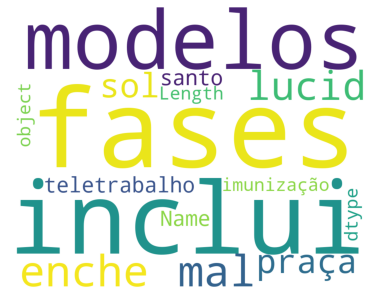

sintomas


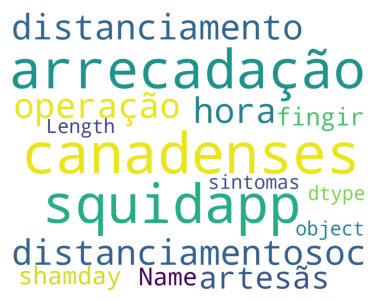

cloroquina


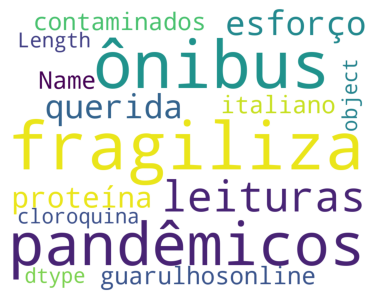

In [40]:

for w in ['imunização', 'sintomas', 'cloroquina']:
    wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white',  
                min_font_size = 10, random_state=0 ).generate(str(df_features[w]))
    
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
      
    print(w)
    plt.show() 

## Localizando tweets

#### Importando dataset com os tweets antes do tratamento 

In [46]:
df = pd.read_csv('tweets_pt01.csv')

In [47]:
len(df)

5141

In [48]:
df['text'][0]

'RT @agenciabrasil: #Covid19 | Brasil tem 125,5 mil mortes e 4,09 milhões de casos acumulados. De acordo com boletim do \n@minsaude, 688.393…'

In [49]:
index_lista = []
for x in range(len(data_pandas)):
    
    
    tweet = df['text'][x]
    
    lista_vazia = re.findall('sintomas', tweet)
    
    if lista_vazia != []:
        
        index_lista.append(x)
    

In [51]:
for i in index_lista:
    
    print(i)
    print()
    print(df['text'].iloc[i])
    print()
    print()

606

RT @portaluai: Seis meses de sintomas de COVID-19: 'Não sei como vou melhorar'; uma mulher decidiu lidar com isso a partir de um diário no…


613

RT @em_com: Seis meses de sintomas de COVID-19: 'Não sei como vou melhorar'; uma mulher decidiu lidar com isso a partir de um diário no Ins…


614

RT @portaluai: Seis meses de sintomas de COVID-19: 'Não sei como vou melhorar'; uma mulher decidiu lidar com isso a partir de um diário no…


615

Seis meses de sintomas de COVID-19: 'Não sei como vou melhorar'; uma mulher decidiu lidar com isso a partir de um d… https://t.co/lhGMdg2z29


616

Seis meses de sintomas de COVID-19: 'Não sei como vou melhorar'; uma mulher decidiu lidar com isso a partir de um d… https://t.co/bct6DBLQLV


998

RT @PesquisaFapesp: https://t.co/hoYthao7V2 Uma mutação que apagou um trecho de #DNA de dois #genes do #SarsCoV2 parece tornar os sintomas…


1024

RT @PesquisaFapesp: https://t.co/hoYthao7V2 Uma mutação que apagou um trecho de #DNA de dois #genes do #SarsC